# Group Project Notebook

In this cell we import all of the module/functions we're going to be using. For readability's sake, I suggest we add them in the order that we use them.

In [154]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime,timedelta
from scipy import optimize

This is where we should read in the data. I didn't realize that the `.txt` file was a in FITS format so I wrote a whole script to get the data in the format we wanted. I think we should find a way to use the `astropy` package to open it like the we did in Lecture 15. 

In [155]:
datapath = 'ASTR19_F25_group_project_data.txt'
height_err_rms = 0.25

### **Step 1. Data and Oscillation**

In [156]:
def get_data(filename = datapath, types = (int,int,float),funcs = (None,'hm2m',None)):
    def hm2m(string):
        # convert hh:mm as a str type into mm as int type
        l = string.split(':')
        l = [int(i) for i in l]
        m = l[0]*60 + l[1]
        return m
    datalist = []
    with open(filename,'r') as file:
        lines = file.readlines()
    for i,l in enumerate(lines):
        items = l.split()
        if items[0].lower() == '#column':
            label = ''.join([c for c in items[1] if c.isalnum()])
            description = ' '.join(items[2:])
            datalist.append({'label':label, 'description':description, 'data':[]})
        else:
            for n,val in enumerate(items):
                if funcs is not None:
                    if funcs[n] == 'hm2m':
                        val = hm2m(val)
                elif types is not None:
                    if types[n] is not None:
                        val = funcs[n](val)
                datalist[n]['data'].append(val)
    for i in range(len(datalist)):
        datalist[i]['data'] = np.array(datalist[i]['data'], dtype=types[i])
    return datalist


Getting data from file.  
 - `day`, `time`, and `height` are all `dict`s with keys: label, description, and `np.array` data  

In [157]:
day, time, height = get_data() 
daydata = day['data']-1  # days started from 1 in the data, shifted to start at 0 
minute_offsets = time['data']
heightdata = height['data']
height_err = np.full_like(heightdata,height_err_rms) # creating measurement error array

# Getting a combined time value as minutes since the start of the first day on which a measurement was taken
timedata = daydata*24*60 + minute_offsets
# Getting datetime-style representation for each datapoint, used in plotting
start_time = datetime(2022,1,1,0,0)  # JUST A GUESS
datedata = [start_time + timedelta(minutes=m) for m in np.astype(timedata,type(int))]

Oscillatory functions likely of the form:  
$ H(t) = \sum\limits_{n=0}^{N} \biggl[A_n * \sin(f_{n}t +b_n) + A'_n * \cos(f'_{n}t +b'_n)\biggr] + \sum\limits_{k=0}^{K} \biggl[A''_{k}*t^{k}\biggr]$  

### **Step 2. Best Fit**

In [158]:
def func(t,m,c1,a1,f1,b1,a2,f2,b2,c2,f3,b3):
    return m*t + c1 + a1*np.cos(f1*t+b1) + (a2*np.cos(f2*t+b2)+c2)*np.cos(f3*t+b3)

Getting best fit parameters and model values.

In [159]:
initial_values = {'m'  : 1.11319456e-05,
      'c1' : 2.14974295e+00,
      'a1' : 1.08192333e+00,
      'f1' : 2.97496057e-04,
      'b1' : 1.20192286e+00,
      'a2' : 1.35356146e+00 ,
      'f2' :  2.95654101e-04,
      'b2' : -4.52219874e-01,
      'c2' : 12,
      'f3' : 8.69199851e-03,
      'b3' : 2.58810054e+00
    }
params,cov = optimize.curve_fit(func,timedata,heightdata,p0=[i for i in initial_values.values()],sigma=height_err_rms)

model_height =func(timedata,*params)

for i,k in enumerate(initial_values):
    # this shows that there is a cycle every 12ish hours and
    # another one every 14-15 days (which aligns with new and full moons)
    if 'f' in k:
        f = params[i]
        period = (2*np.pi)/f
        period = timedelta(minutes=period)
        pstring = str(period)
        print(f'{k} = {pstring}')

f1 = 14 days, 11:24:14.182514
f2 = 14 days, 2:57:29.058023
f3 = 11:58:42.492352


Plotting data, with measurement error, and fit.

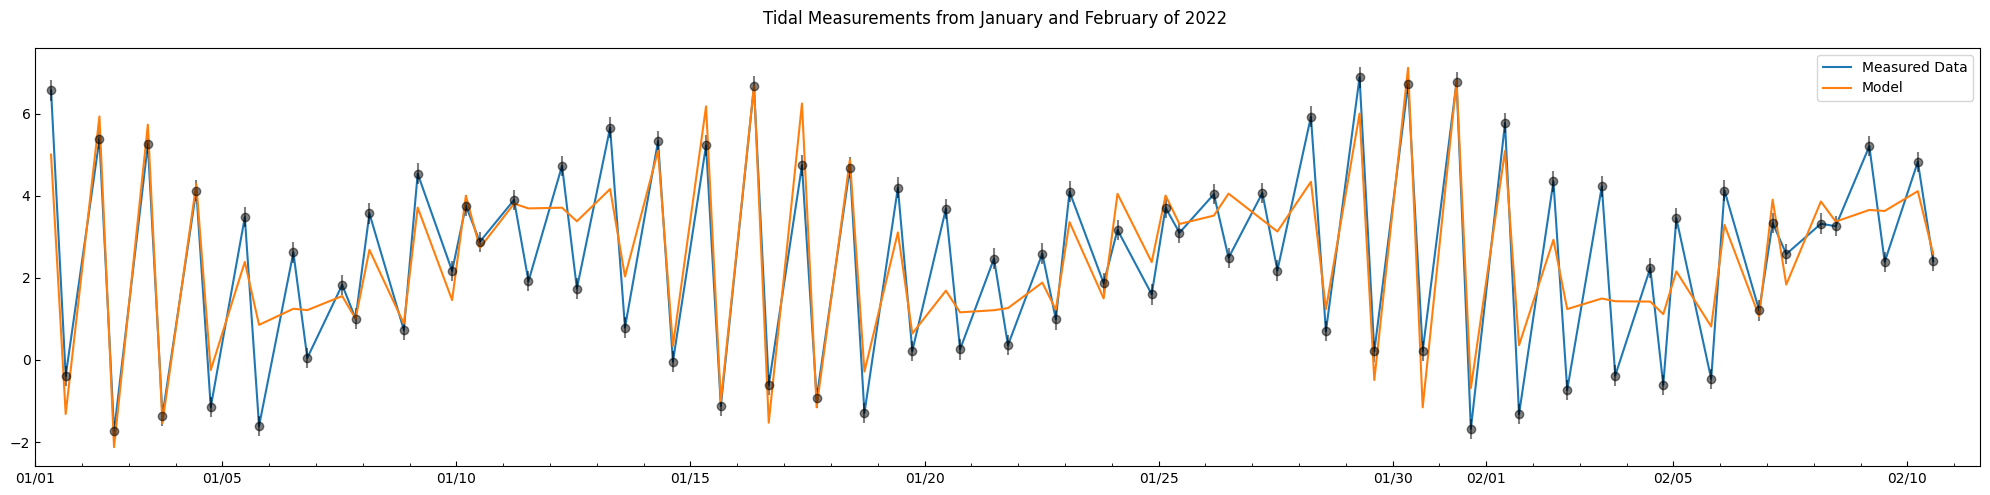

In [160]:
fig,ax = plt.subplots(1,1,figsize=(20,5), )

fig.suptitle('Tidal Measurements from January and February of 2022')

ax.plot(datedata,heightdata, label = 'Measured Data')
ax.errorbar(datedata,heightdata,height_err,fmt='o',alpha=0.5,color='black')
ax.plot(datedata,model_height, label = 'Model')

# Tick and tick label formatting. See: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
# For x-axis (time)
date_major_format = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_major_format)
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1]+[i for i in range(5,32,5)]))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.tick_params(axis='both',which='both',direction='in',)

ax.set_xlim(start_time, datedata[-1]+timedelta(days=1))
plt.tight_layout()
plt.legend()
# plt.show()
fig.savefig('testbed.pdf',bbox_inches = 'tight',dpi = 300)

### **Step 3. Residuals**

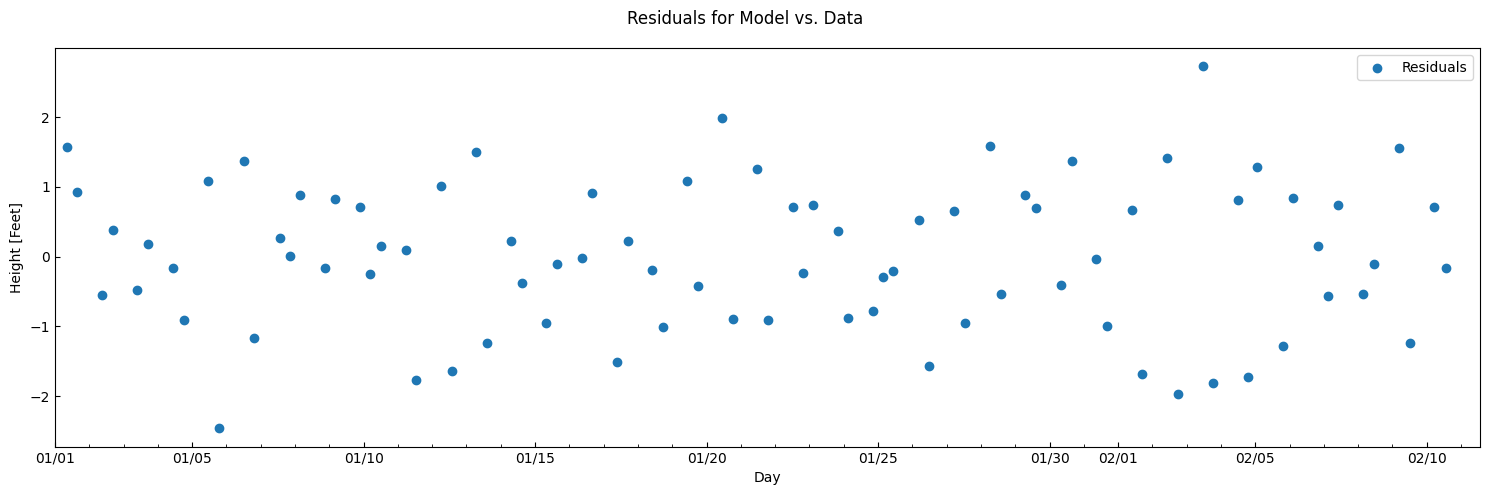

In [ ]:
residuals = heightdata - model_height
fig,ax = plt.subplots(1,1,figsize=(15,5))

fig.suptitle('Residuals for Model vs. Data')

#pick start time
start_time = datetime(2022,1,1,0,0)
# for each minute data point, offset start date by that many minutes
datedata = [start_time + timedelta(minutes=m) for m in np.astype(timedata,type(int))] 
# create and use format for major ticks. See: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
date_major_format = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_major_format)
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1]+[i for i in range(5,32,5)]))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.tick_params(axis='both',which='both',direction='in',)

ax.set_xlim(start_time, datedata[-1]+timedelta(days=1))

ax.scatter(datedata,residuals, label = 'Residuals')
ax.set_xlabel('Day')
ax.set_ylabel('Height [Feet]')
ax.tick_params(axis='both',which='both',direction='in',)

plt.tight_layout()
plt.legend()
plt.show()
fig.savefig('Residuals.pdf',bbox_inches = 'tight',dpi = 300)

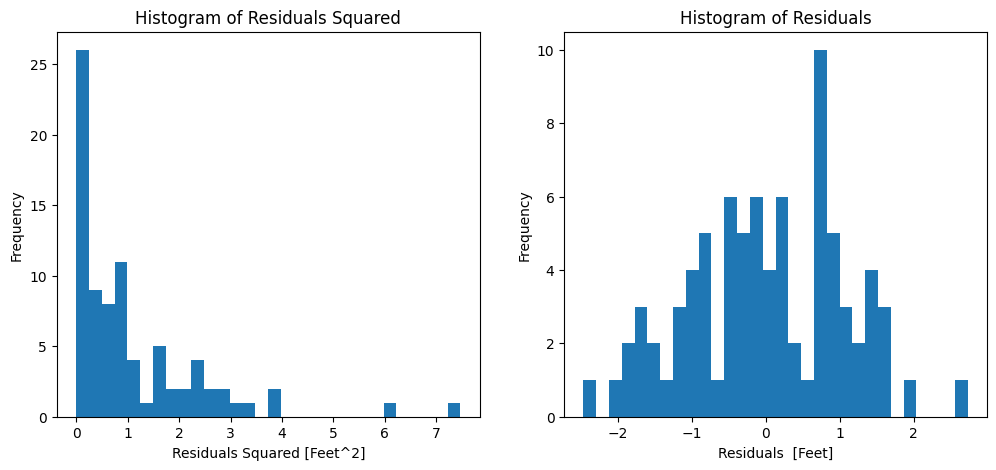

In [162]:
residuals_squared = residuals**2 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

_ = axes[0].hist(residuals_squared, bins=30)
_ = axes[0].set_xlabel('Residuals Squared [Feet^2]')
_ = axes[0].set_ylabel('Frequency')
_ = axes[0].set_title('Histogram of Residuals Squared')

_ = axes[1].hist(residuals, bins=30)
_ = axes[1].set_xlabel('Residuals  [Feet]')
_ = axes[1].set_ylabel('Frequency')
_ = axes[1].set_title('Histogram of Residuals')

In [163]:
#Standard deviation and mean of Residual
res_std = np.std(residuals)
res_mean = np.mean(residuals) 
print(f"Residuals mean: {res_mean}.")
print(f"Residuals std: {res_std}.")

Residuals mean: 8.395658197329768e-07.
Residuals std: 1.0433500312624855.


In [170]:
# estimating intrinsic scatter
sigma_intrinsic = np.sqrt(res_std**2 -height_err_rms**2)
print(f'Estimate of intrinsic scatter: {sigma_intrinsic}')

Estimate of intrinsic scatter: 1.0129557185461906


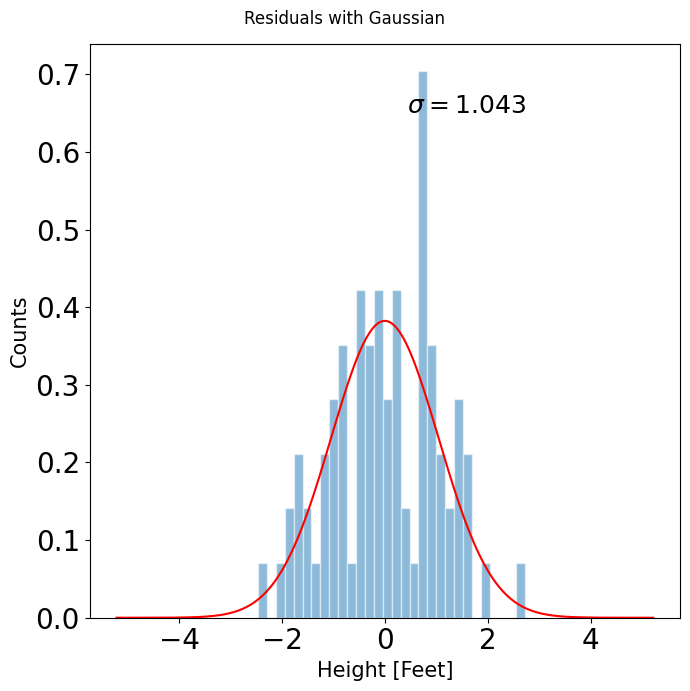

In [164]:
f,ax = plt. subplots (1,1, figsize= (7,7))
for tick in ax. xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)
def gaussian (x, mean, std):
    return (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

_ = ax.hist(residuals,bins=30, alpha=0.5, edgecolor="white", density=True)
_ = x_g = np.linspace(-5*res_std, 5*res_std, 1000)
_ = ax.plot(x_g, gaussian(x_g, res_mean, res_std), color="red")
_ = ax.text(0.3,.65,f' $\\sigma = {res_std:.3f}$', color='0', fontsize=18)
_ = ax.set_xlabel('Height [Feet]',fontsize=15)
_ = ax.set_ylabel('Counts' ,fontsize=15)
_ = f.suptitle('Residuals with Gaussian')
plt.tight_layout()

### Step 4. The Outlier

outlier sigma = 2.1375457927798016


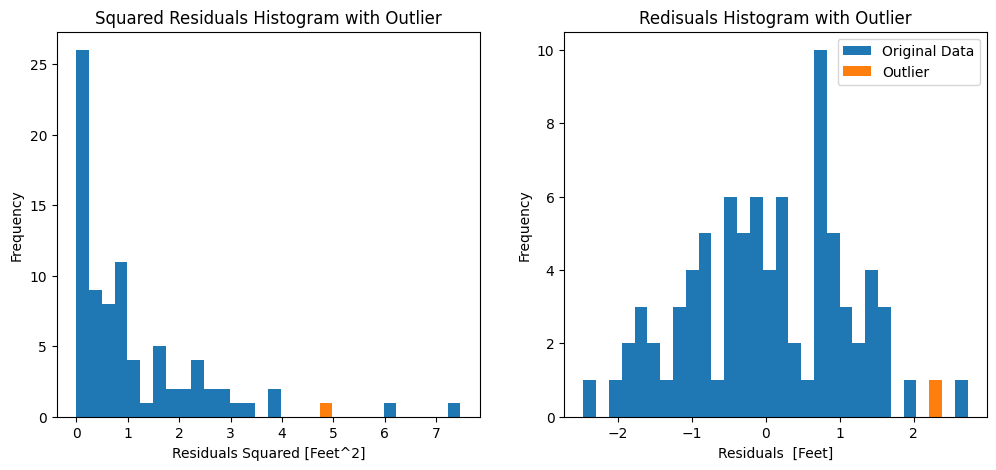

In [169]:
# Adding 2 feet to first high tide of January 14
outlier_index = 26
outlier_height_data = heightdata.copy()
outlier_height_data[outlier_index] += 2
outlier_model_height = func(timedata, *params)
outlier_residuals = outlier_height_data - outlier_model_height

outlier_residuals_squared = outlier_residuals**2 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

_ = axes[0].hist(residuals_squared, bins=30, zorder=2)
_ = axes[0].hist(outlier_residuals_squared, bins=30, zorder=1)
_ = axes[0].set_xlabel('Residuals Squared [Feet^2]')
_ = axes[0].set_ylabel('Frequency')
_ = axes[0].set_title('Squared Residuals Histogram with Outlier')

_ = axes[1].hist(residuals, bins=30, zorder=2, label = 'Original Data')
_ = axes[1].hist(outlier_residuals, bins=30, zorder=1, label = 'Outlier')
_ = axes[1].set_xlabel('Residuals  [Feet]')
_ = axes[1].set_ylabel('Frequency')
_ = axes[1].set_title('Redisuals Histogram with Outlier')
_ = plt.legend()

print(f'outlier sigma = {(outlier_residuals[outlier_index]-res_mean)/res_std}')